In [1]:
import numpy as np 
import pandas as pd 
import os
import cv2 
import PIL 
import gc
import psutil
import matplotlib.pyplot as plt
from sklearn.model_selection import  train_test_split
from tensorflow import set_random_seed
from tqdm import tqdm
from math import ceil

import keras
from keras.preprocessing import image
from keras.models import Sequential, Model
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Input
from keras.layers import Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.activations import softmax, relu
from keras.optimizers import Adam, rmsprop, RMSprop
from keras.layers import BatchNormalization

from tqdm import tqdm


Using TensorFlow backend.


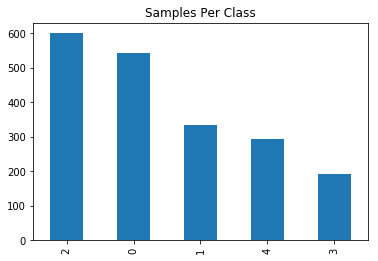

In [115]:
SEED = 7
np.random.seed(SEED) 
set_random_seed(SEED)

# take in 2019 data
df_train = pd.read_csv("../aptos2019/train.csv") 
df_test  = pd.read_csv("../aptos2019/test.csv")

# point data to file types
df_train.id_code = df_train.id_code.apply(lambda x: x + ".png")
df_test.id_code  = df_test.id_code.apply(lambda  x: x + ".png")

df_train.diagnosis  = df_train.diagnosis.astype('str')

# get rid of a lot of the more common classes
indexes_0 = df_train[ df_train['diagnosis'] == '0' ].index
df_train.drop(indexes_0[:int(0.7*indexes_0.size)], inplace=True)
indexes_1 = df_train[ df_train['diagnosis'] == '1' ].index
df_train.drop(indexes_1[:int(0.1*indexes_1.size)], inplace=True)
indexes_2 = df_train[ df_train['diagnosis'] == '2' ].index
df_train.drop(indexes_2[:int(0.4*indexes_2.size)], inplace=True)

df_train['diagnosis'].value_counts().plot(kind='bar');
plt.title('Samples Per Class');

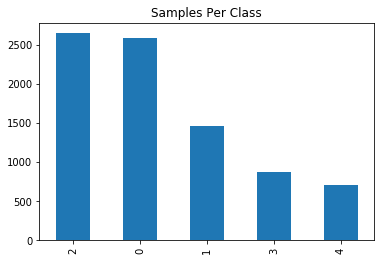

In [118]:
# import the 2015 data
df_train_2015 = pd.read_csv("../aptos2015/trainLabels.csv") 
df_train_2015.image = df_train_2015.image.apply(lambda x: x + ".jpeg")
df_train_2015.level = df_train_2015.level.astype('str')

# get rid of a lot of the more common classes
indexes_0 = df_train_2015[ df_train_2015['level'] == '0' ].index
df_train_2015.drop(indexes_0[:int(0.9*indexes_0.size)], inplace=True)
indexes_1 = df_train_2015[ df_train_2015['level'] == '1' ].index
df_train_2015.drop(indexes_1[:int(0.4*indexes_1.size)], inplace=True)
indexes_2 = df_train_2015[ df_train_2015['level'] == '2' ].index
df_train_2015.drop(indexes_2[:int(0.5*indexes_2.size)], inplace=True)

df_train_2015['level'].value_counts().plot(kind='bar');
plt.title('Samples Per Class');

In [31]:
IMG_DIM      = 300
BATCH_SIZE   = 24
CHANNEL_SIZE = 3
NUM_EPOCHS   = 12
# FREEZE_LAYERS = 2  # freeze the first this many layers for training
NUM_CLASSES = df_train['diagnosis'].nunique()

class_names = {"0":"No DR", "1":"Mild", "2":"Moderate", "3":"Severe", "4":"Proliferative DR"}

df_train.columns, df_test.columns, NUM_CLASSES


(Index(['id_code', 'diagnosis'], dtype='object'),
 Index(['id_code'], dtype='object'),
 5)

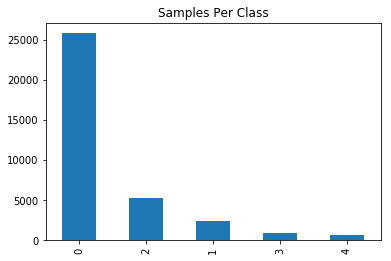

In [45]:
# df_train['diagnosis'].value_counts().plot(kind='bar');
# plt.title('Samples Per Class');

df_train_2015['level'].value_counts().plot(kind='bar');
plt.title('Samples Per Class');


In [119]:
# assumes RGB
def colourfulEyes(img):
        
    # convert to y, cr, cb so that we can modify the image based on just the y (brightness)
    ycc = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    y, cr, cb = cv2.split(ycc)

    # perform bens algorithm on the y component
    y = cv2.addWeighted(y, 3, cv2.GaussianBlur(y, (0,0), 60),-3, 128)

    # merge the ycc back together, and recolor it
    ycc_modified = cv2.merge((y, cr, cb))
    rgb_modified = cv2.cvtColor(ycc_modified, cv2.COLOR_YCrCb2RGB)
    
    return rgb_modified 

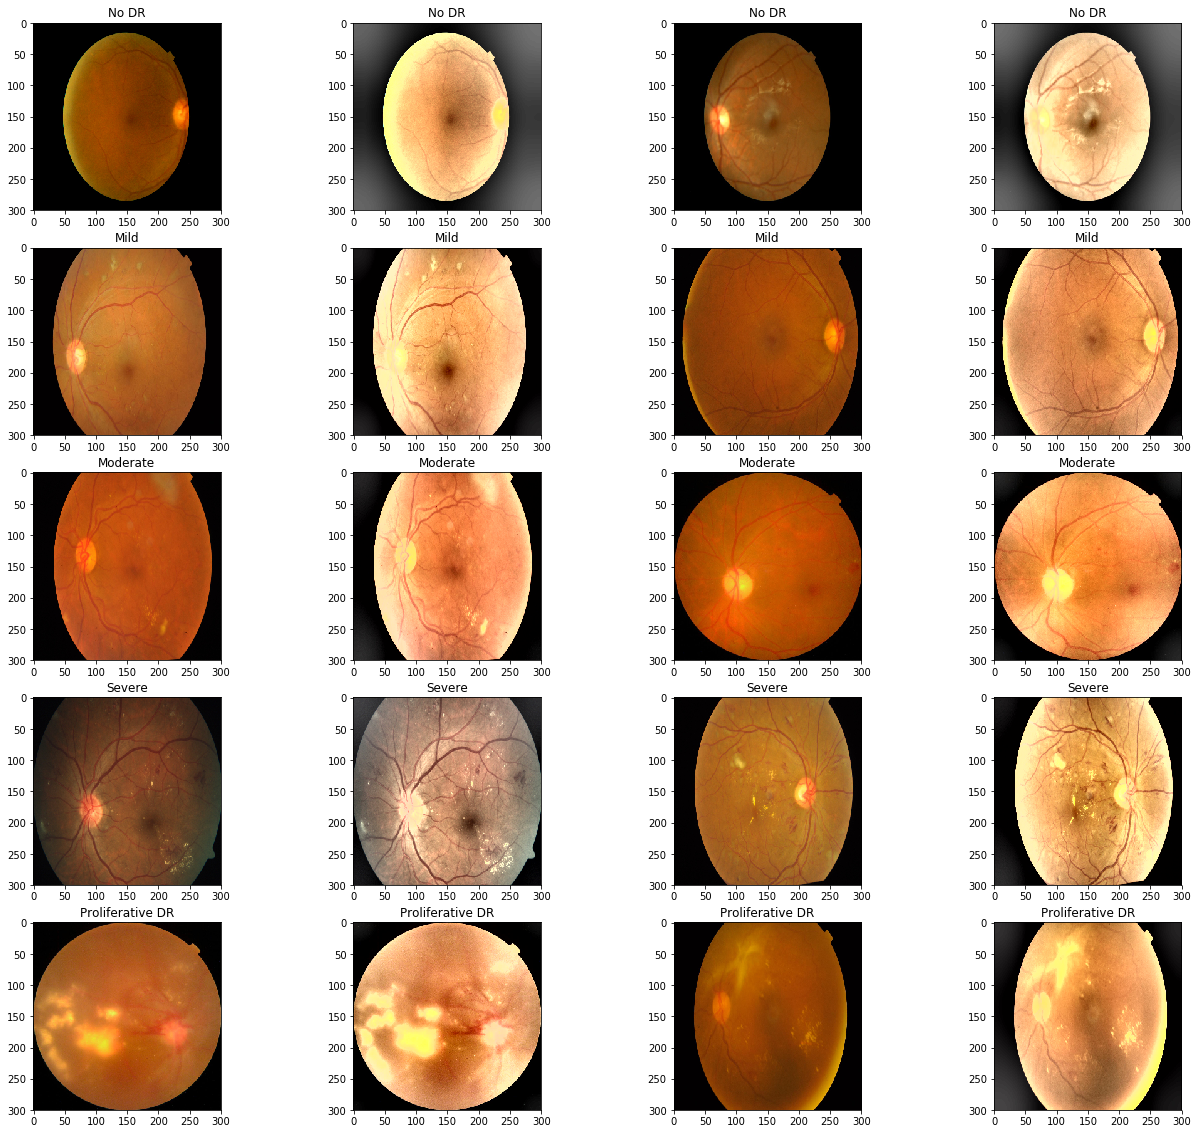

In [120]:
# Display some random images from Data Set with class categories.
figure=plt.figure(figsize=(22,20))
for target_class in (df_train['diagnosis'].unique()):
    for i, (idx, row ) in enumerate(df_train.loc[df_train.diagnosis == target_class]
                                    .sample(2)
                                    .iterrows()):
        # open the file
        imagefile = f"../aptos2019/train_images/{row['id_code']}" 
        img = cv2.imread(imagefile)
        img = cv2.resize(img, (IMG_DIM, IMG_DIM))
        
        # original version
        rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax = figure.add_subplot(5,4, int(target_class)*4+2*i+1)
        plt.imshow(rgb)
        ax.set_title(class_names[target_class])
        
        # colored version
        funky = colourfulEyes(rgb)
        ax = figure.add_subplot(5,4, int(target_class)*4+2*i+2)
        plt.imshow(funky)
        ax.set_title(class_names[target_class])
        

In [121]:
# Data generators, which put their data into a random crop generator, which is then fed into
# the network during training
ZOOM = 0.8
datagen = image.ImageDataGenerator(rescale=1./255,
                                   validation_split=0.2,
                                   horizontal_flip=True, 
                                   vertical_flip=True,
                                   rotation_range=20,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.1,
                                   zoom_range=[0.9*ZOOM, 1.1*ZOOM],
                                   fill_mode="reflect",
                                   preprocessing_function=colourfulEyes
                                  )

# 2019
train_generator = datagen.flow_from_dataframe(dataframe=df_train,
                                              directory="../aptos2019/train_images/",
                                              x_col="id_code",
                                              y_col="diagnosis",
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical",
                                              target_size=(IMG_DIM, IMG_DIM),
                                              subset='training', 
                                              interpolation="bilinear",
                                              seed=SEED,
                                             )
valid_generator = datagen.flow_from_dataframe(dataframe=df_train,
                                              directory="../aptos2019/train_images/",
                                              x_col="id_code",
                                              y_col="diagnosis",
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical",
                                              target_size=(IMG_DIM, IMG_DIM),
                                              subset='validation',
                                              interpolation="bilinear",
                                              seed=SEED
                                             )

# 2015
valid_generator_2015 = datagen.flow_from_dataframe(dataframe=df_train_2015,
                                                  directory="../aptos2015/train_images/",
                                                  x_col="image",
                                                  y_col="level",
                                                  batch_size=BATCH_SIZE,
                                                  class_mode="categorical",
                                                  target_size=(IMG_DIM, IMG_DIM),
                                                  subset='training',
                                                  interpolation="bilinear",
                                                  seed=SEED
                                                 )
valid_generator_2015 = datagen.flow_from_dataframe(dataframe=df_train_2015,
                                                  directory="../aptos2015/train_images/",
                                                  x_col="image",
                                                  y_col="level",
                                                  batch_size=BATCH_SIZE,
                                                  class_mode="categorical",
                                                  target_size=(IMG_DIM, IMG_DIM),
                                                  subset='validation',
                                                  interpolation="bilinear",
                                                  seed=SEED
                                                 )

gc.collect()


Found 1571 validated image filenames belonging to 5 classes.
Found 392 validated image filenames belonging to 5 classes.
Found 6620 validated image filenames belonging to 5 classes.
Found 1654 validated image filenames belonging to 5 classes.


254879

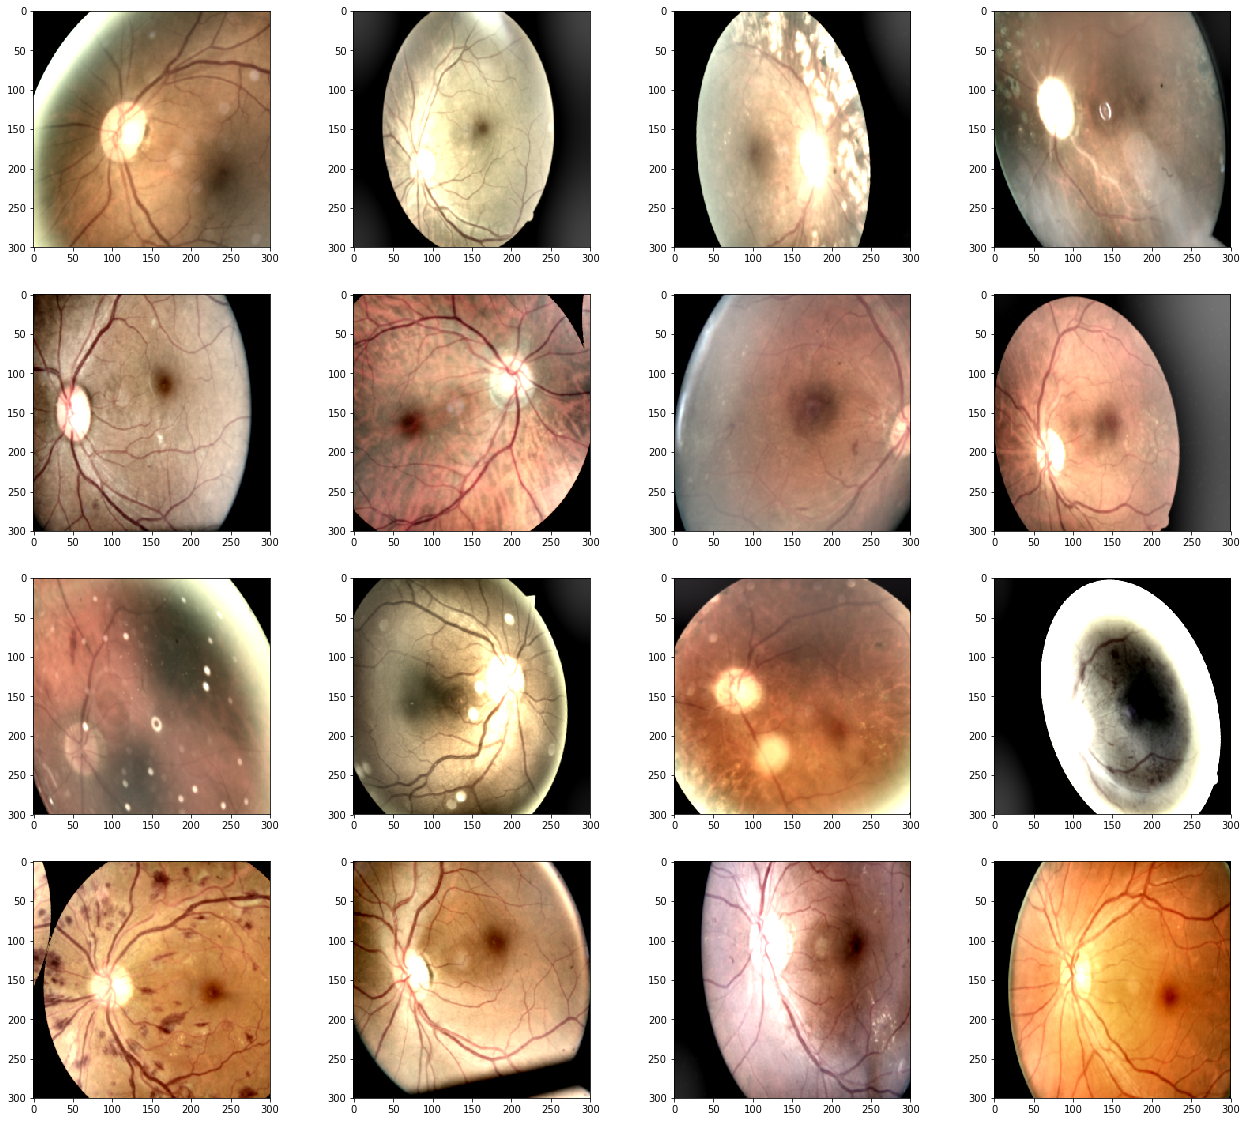

In [123]:
# Display some data generation
figure=plt.figure(figsize=(22,20))
for batch in valid_generator_2015:
    for j in range(16):
        ax = figure.add_subplot(4,4, j+1)
        batch[0][j] = np.clip(batch[0][j], 0, 1)
        plt.imshow(batch[0][j])
    break

In [36]:
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=3, verbose=1, mode='auto')
reduce_lr  = ReduceLROnPlateau(monitor='val_loss', 
                               min_delta=0.0004, 
                               patience=2, 
                               factor=0.1, 
                               min_lr=1e-6,  
                               mode='auto', 
                               verbose=1
                              )

NUM_TRAIN_STEPS = train_generator.n // train_generator.batch_size
NUM_VALID_STEPS = valid_generator.n // valid_generator.batch_size

NUM_TRAIN_STEPS, NUM_VALID_STEPS


(122, 30)

In [37]:
def create_resnet(img_dim, CHANNELS, n_class):
    input_tensor=Input(shape=(img_dim, img_dim, CHANNELS))
  
    base_model = ResNet50(weights=None, include_top=False, input_tensor=input_tensor)
    base_model.load_weights('../resnet50/base.h5')
    
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.2)(x)
    x = Dense(1024, activation=relu)(x)
    x = Dropout(0.15)(x)
    x = Dense(512,  activation=relu)(x)
    x = Dropout(0.15)(x)
    x = BatchNormalization()(x)
    output_layer = Dense(n_class, activation='softmax', name="Output_Layer")(x)
    model_resnet = Model(input_tensor, output_layer)
    
    return model_resnet

model_resnet=create_resnet(IMG_DIM, CHANNEL_SIZE, NUM_CLASSES)


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [38]:
# todo: don't think this is thinking of frozen layers
for layers in model_resnet.layers:
    layers.trainable = True

lr = 1e-3
optimizer = rmsprop(lr=lr, decay=0.1)
model_resnet.compile(optimizer=optimizer, loss=keras.losses.categorical_crossentropy,  metrics=['accuracy'])
# model_resnet.summary()
gc.collect()

365

In [ ]:
# train the model for 12 epochs
history = model_resnet.fit_generator(generator=train_generator,
                                      steps_per_epoch=NUM_TRAIN_STEPS,
                                      validation_data=valid_generator,
                                      validation_steps=NUM_VALID_STEPS,
                                      epochs=NUM_EPOCHS,
                                      callbacks=[early_stop, reduce_lr],
                                      verbose=1
                                     )
gc.collect()

Epoch 1/12
  8/122 [>.............................] - ETA: 12:53 - loss: 0.7655 - acc: 0.7083

In [ ]:
# train on 2015 stuff
history = model_resnet.fit_generator(generator=train_generator_2015,
                                      steps_per_epoch=NUM_TRAIN_STEPS,
                                      validation_data=valid_generator_2015,
                                      validation_steps=NUM_VALID_STEPS,
                                      epochs=4,
                                      callbacks=[early_stop, reduce_lr],
                                      verbose=1
                                     )
gc.collect()

Epoch 1/12
122/122 [==============================] - 594s 5s/step - loss: 0.8627 - acc: 0.6889 - val_loss: 0.9098 - val_acc: 0.7069
Epoch 2/12
122/122 [==============================] - 549s 5s/step - loss: 0.6295 - acc: 0.7589 - val_loss: 0.6380 - val_acc: 0.7669
Epoch 3/12
122/122 [==============================] - 546s 4s/step - loss: 0.6076 - acc: 0.7719 - val_loss: 0.5873 - val_acc: 0.7910
Epoch 4/12
122/122 [==============================] - 546s 4s/step - loss: 0.5485 - acc: 0.7917 - val_loss: 0.5882 - val_acc: 0.7867
Epoch 5/12
108/122 [=========================>....] - ETA: 51s - loss: 0.5485 - acc: 0.7901

In [ ]:
# STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
(eval_loss, eval_accuracy)=tqdm(model_resnet.evaluate_generator(generator=valid_generator,steps=NUM_VALID_STEPS, pickle_safe=False))
print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100)) 
print("[INFO] Loss: {}".format(eval_loss)) 


# as it was, with the eye colouring
# [INFO] accuracy: 84.71%
# [INFO] Loss: 0.45822140898023334

In [ ]:
test_datagen = image.ImageDataGenerator(rescale=1./255,
                                        horizontal_flip=True
                                       )

test_generator = test_datagen.flow_from_dataframe(dataframe = df_test,
                                                  directory = "../aptos2019/test_images/",
                                                  x_col="id_code",
                                                  target_size=(IMG_DIM, IMG_DIM),
                                                  batch_size=1,
                                                  shuffle=False, 
                                                  class_mode=None, 
                                                  interpolation="bilinear",
                                                  seed=SEED
                                                 )
# del df_test
print(df_test.shape[0])
gc.collect()

In [ ]:
tta_steps = 10
preds_tta=[]
for i in tqdm(range(tta_steps)):
    test_generator.reset()
    preds = model_resnet.predict_generator(generator=test_generator, steps = ceil(df_test.shape[0]))
#     print('Before ', preds.shape)
    preds_tta.append(preds)
#     print(i,  len(preds_tta))